In [19]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
plt.rcParams["figure.figsize"] = (20,10)
# %matplotlib inline

In [20]:
data = pd.read_csv("billrun_data_with_1lac_data.csv")
data.drop('Unnamed: 0',axis = 1,inplace = True)
data.head()

,CustomerType,NoOfContract,CurrentBillWithoutTax,TaxCode,TotalTax,CurrentBillWithTax,Adjustment,LastMonthPendingAmount,TotalAmountToPay,Anomaly,TypeOfAnomaly
0,r,12,692.6,0,83.112,775.712,0.0,159.0,934.712,0,NaN
1,v,10,1445.5,0,173.460,1618.960,0.0,574.0,2192.960,0,NaN
2,v,36,5224.2,1,940.356,6164.556,5916.0,5711.0,5959.556,0,NaN
3,r,12,698.6,0,83.832,782.432,0.0,0.0,782.432,0,NaN
4,r,12,716.6,0,85.992,802.592,0.0,0.0,802.592,0,NaN


In [21]:
data.fillna(value = 0, inplace = True)
data['CustomerType'] = pd.Categorical(data.CustomerType)
data['TaxCode'] = pd.Categorical(data.TaxCode)
data['TypeOfAnomaly'] = pd.Categorical(data.TypeOfAnomaly)
le = LabelEncoder()
data['CustomerType'] = le.fit_transform(data['CustomerType'])
data['TaxCode'] = le.fit_transform(data.TaxCode)
data = pd.get_dummies(data)
data.drop(['TypeOfAnomaly_0','TypeOfAnomaly_CustomerType Anomaly','TypeOfAnomaly_Product Anomaly','TypeOfAnomaly_TaxCode Anomaly','TotalTax', 'CurrentBillWithTax', 'Adjustment','LastMonthPendingAmount','TotalAmountToPay'],axis = 1, inplace = True)
data.rename({'CustomerType' : 'type', 'NoOfContract' : '#contract', 'CurrentBillWithoutTax' : 'CurrentBillWithoutTax','TaxCode' : 'TaxCode', 'TypeOfAnomaly_Adjustment Anomaly' : 'AdjustmentIssue', 'TypeOfAnomaly_LastMonthPendingAmount Anomaly' : 'LastMonthIssue','Anomaly' : 'label'},inplace=True, axis = 1)
# numerical_colms = ['#contract','CurrentBillWithoutTax']

In [22]:
data.head()

,type,#contract,CurrentBillWithoutTax,TaxCode,label,AdjustmentIssue,LastMonthIssue
0,0,12,692.6,0,0,0,0
1,1,10,1445.5,0,0,0,0
2,1,36,5224.2,1,0,0,0
3,0,12,698.6,0,0,0,0
4,0,12,716.6,0,0,0,0


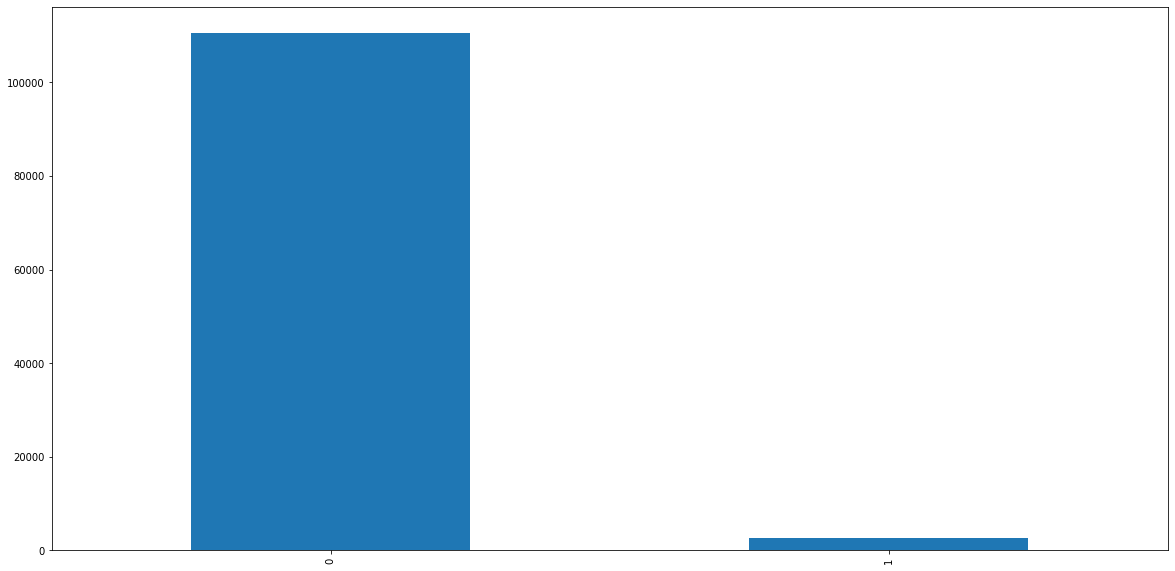

In [23]:
data['label'].value_counts().plot(kind = 'bar')  ## Imabalanced Data

In [24]:
test = pd.read_csv('billrun_data_with_multi_features.csv')
test.fillna(value = 0, inplace = True)
test['CustomerType'] = pd.Categorical(test.CustomerType)
test['TaxCode'] = pd.Categorical(test.TaxCode)
test['TypeOfAnomaly'] = pd.Categorical(test.TypeOfAnomaly)
le = LabelEncoder()
test['CustomerType'] = le.fit_transform(test['CustomerType'])
test['TaxCode'] = le.fit_transform(test.TaxCode)
test = pd.get_dummies(test)
test.drop(['TypeOfAnomaly_0','TypeOfAnomaly_CustomerType Anomaly','TypeOfAnomaly_Product Anomaly','TypeOfAnomaly_TaxCode Anomaly','TotalTax', 'CurrentBillWithTax', 'Adjustment','LastMonthPendingAmount','TotalAmountToPay'],axis = 1, inplace = True)
test.rename({'CustomerType' : 'type', 'NoOfContract' : '#contract', 'CurrentBillWithoutTax' : 'CurrentBillWithoutTax','TaxCode' : 'TaxCode', 'TypeOfAnomaly_Adjustment Anomaly' : 'AdjustmentIssue', 'TypeOfAnomaly_LastMonthPendingAmount Anomaly' : 'LastMonthIssue','Anomaly' : 'label'},inplace=True, axis = 1)
# test[numerical_colms] = StandardScaler().fit_transform(test[numerical_colms])
test.head()

,type,#contract,CurrentBillWithoutTax,TaxCode,label,AdjustmentIssue,LastMonthIssue
0,0,5,269.75,0,0,0,0
1,1,12,1711.40,0,0,0,0
2,0,12,721.60,0,0,0,0
3,0,8,456.40,0,0,0,0
4,1,3,411.35,0,0,0,0


# OneClassSVM

In [25]:
class0 = data[data['label']==0]
class1 = data[data['label']==1]
outlier_prop = class1.shape[0] / class0.shape[0]
model = OneClassSVM(verbose = True, nu=outlier_prop)
model.fit(class0.drop('label', axis = 1))

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.024752967553542532, shrinking=True, tol=0.001,
            verbose=True)

In [26]:
predictions = model.predict(test.drop('label',axis = 1))
# sns.heatmap(confusion_matrix(test['label'], (predictions + 1) // 2), annot=True)

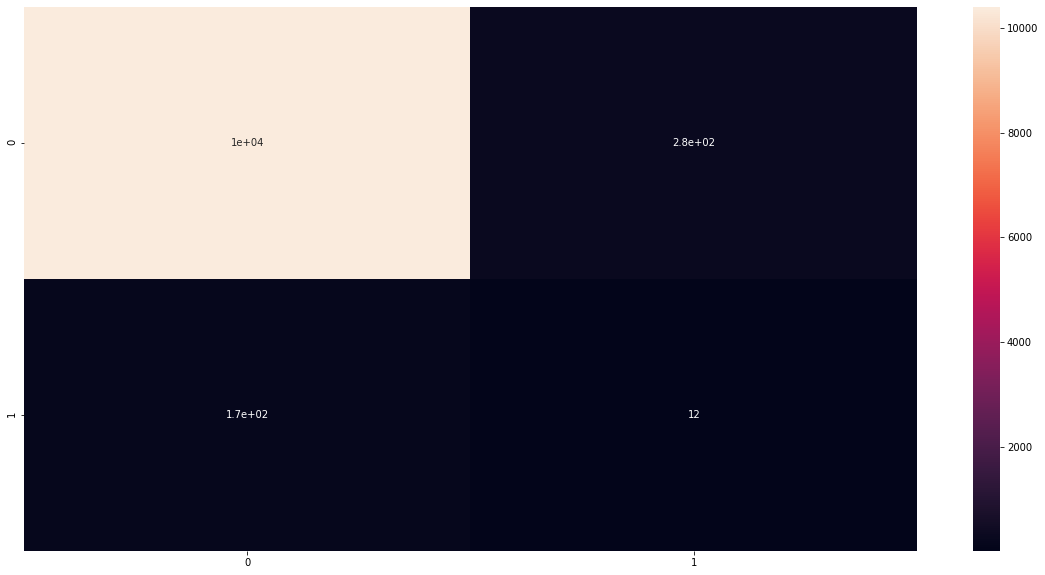

In [27]:
def flip(x):
    if x==1:
        return 0
    else:
        return 1
temp = test.copy()

temp['predictions'] = (predictions + 1) // 2
temp['predictions'] = temp['predictions'].apply(lambda x : 1 if x==0 else 0)

sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot = True)
# temp['predictions'].value_counts()

In [28]:
f1scores = []
f1scores.append(f1_score(temp.label, temp.predictions))

In [29]:
recall = []
recall.append(recall_score(temp.label, temp.predictions))
precison = []
precison.append(precision_score(temp.label, temp.predictions))

In [30]:
models = [type(model).__name__]

## Isolation Forest

In [31]:
model = IsolationForest(contamination=outlier_prop, verbose=True)
model.fit(data.drop('label',axis = 1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


IsolationForest(behaviour='deprecated', bootstrap=False,
                contamination=0.024752967553542532, max_features=1.0,
                max_samples='auto', n_estimators=100, n_jobs=None,
                random_state=None, verbose=True, warm_start=False)

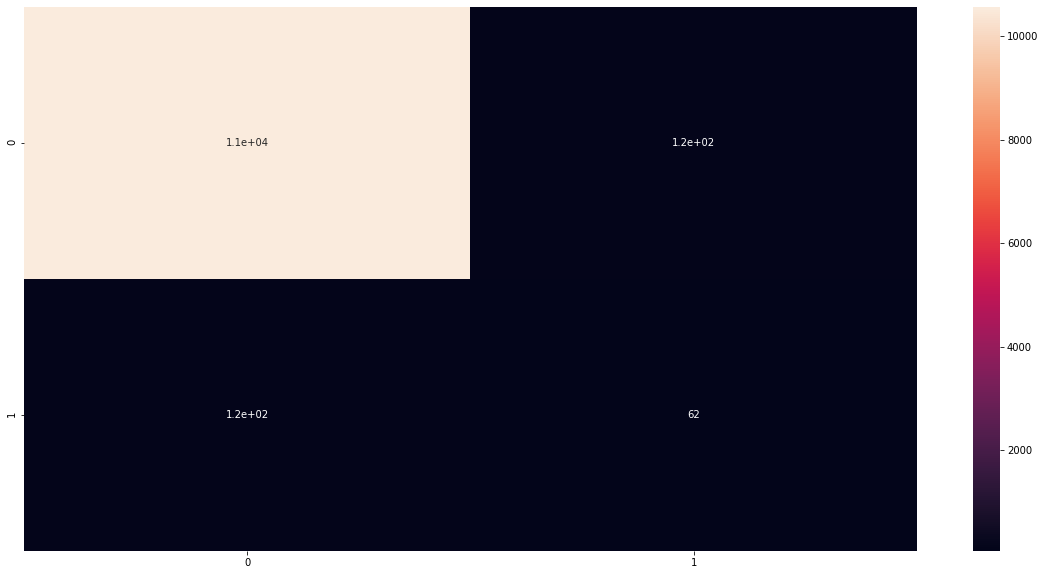

In [32]:
predictions = (model.predict(test.drop('label', axis = 1)) + 1) // 2
temp = test.copy()
temp['predictions'] = predictions
temp['predictions'] = temp['predictions'].apply(lambda x: 1 if x==0 else 0)
sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot=True)

In [33]:
f1scores.append(f1_score(temp.label, temp.predictions))
recall.append(recall_score(temp.label, temp.predictions))
precison.append(precision_score(temp.label, temp.predictions))
models.append(type(model).__name__)

## LOF

In [34]:
model = LocalOutlierFactor(novelty=True)
model.fit(data.drop('label',axis = 1))

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=True, p=2)

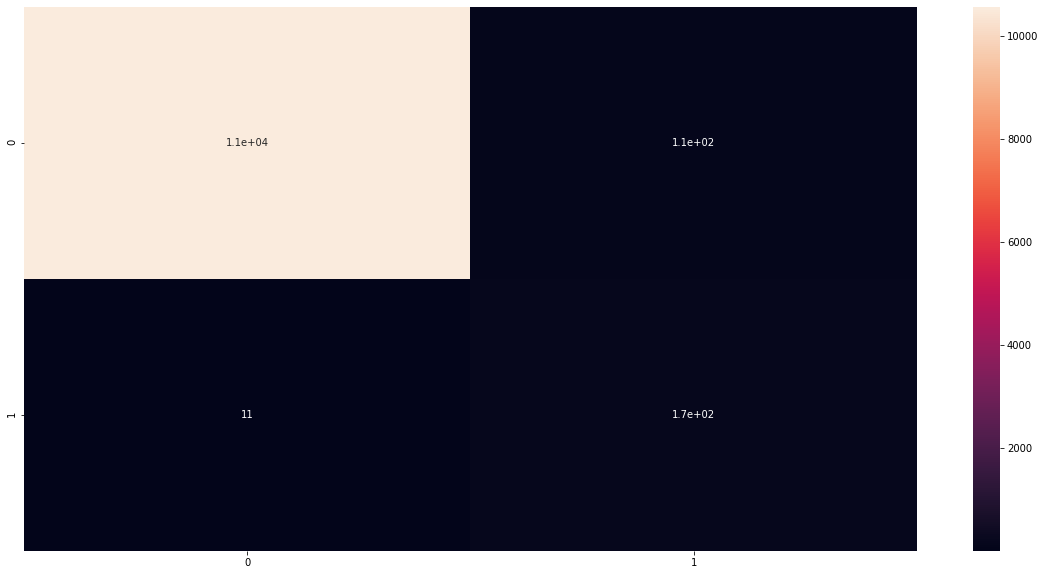

In [35]:
predictions = (model.predict(test.drop('label', axis = 1)) + 1) // 2
temp = test.copy()
temp['predictions'] = predictions
temp['predictions'] = temp['predictions'].apply(lambda x: 1 if x==0 else 0)
sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot=True)

In [36]:
f1scores.append(f1_score(temp.label, temp.predictions))
recall.append(recall_score(temp.label, temp.predictions))
precison.append(precision_score(temp.label, temp.predictions))
models.append(type(model).__name__)

## RandomForest

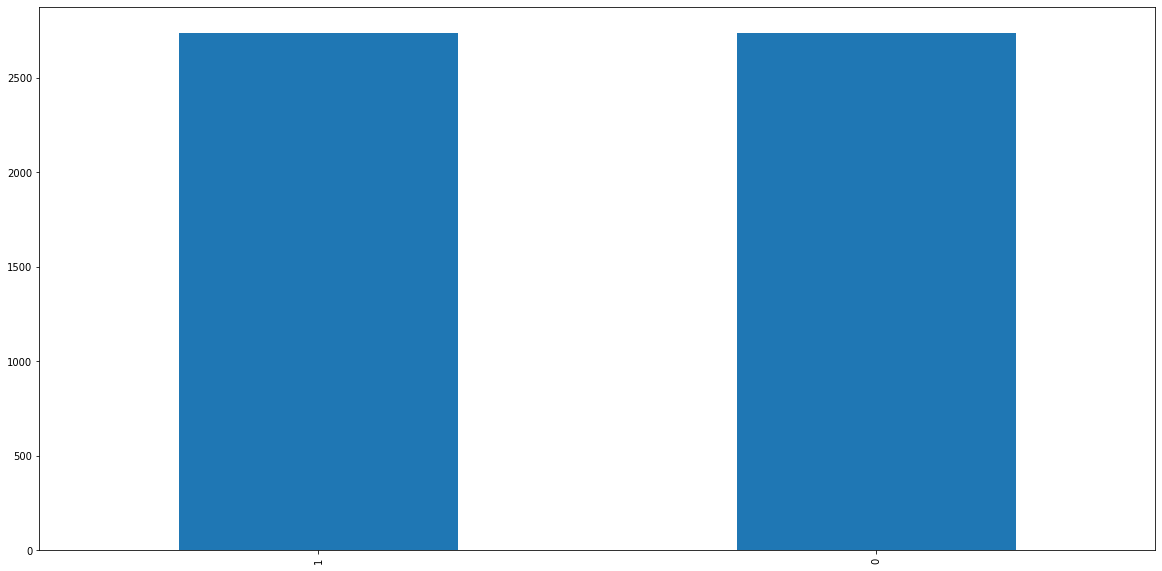

In [37]:
## Process of balancing the data for training a classifier


def balance_data(data, label):
    class1 = data[data[label] == 1]
    size = class1.shape[0]
    class0 = data[data[label] == 0].sample(n = size)
    new_data = pd.concat([class0,class1],ignore_index=True)
    return new_data

new_data = balance_data(data.copy(),'label')
new_data['label'].value_counts().plot(kind = 'bar')

In [38]:
model = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=True,
    warm_start=False,
    class_weight='balanced'
)

model.fit(new_data.drop('label',axis = 1), new_data['label'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=True,
                       warm_start=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


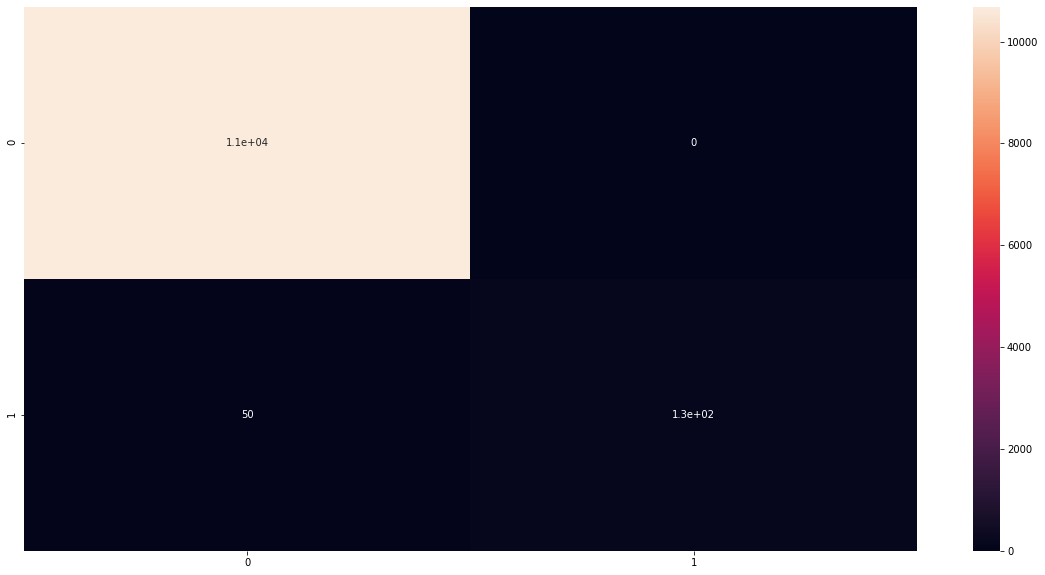

In [39]:
predictions = model.predict(test.drop('label', axis = 1))
temp = test.copy()
temp['predictions'] = predictions
sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot=True)

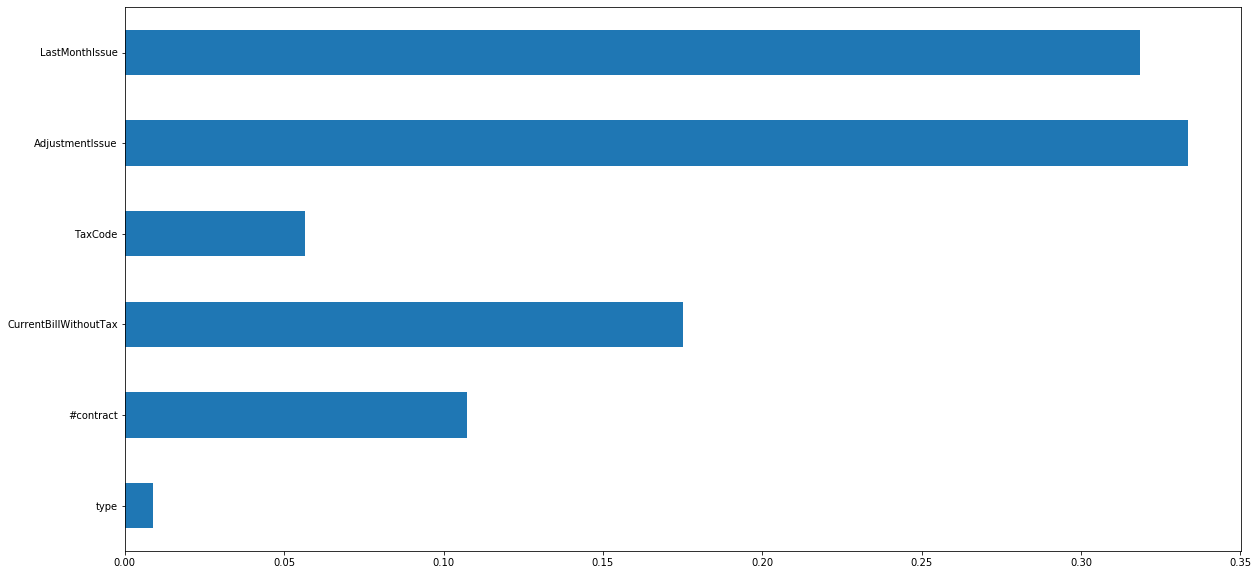

In [40]:
(pd.Series(model.feature_importances_, index = data.drop('label', axis = 1).columns).plot(kind = 'barh'))

In [41]:
f1scores.append(f1_score(temp.label, temp.predictions))
recall.append(recall_score(temp.label, temp.predictions))
precison.append(precision_score(temp.label, temp.predictions))
models.append(type(model).__name__)

## SVM

In [42]:
model = SVC(verbose=True, kernel='linear')
model.fit(new_data.drop('label',axis = 1), new_data['label'])

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

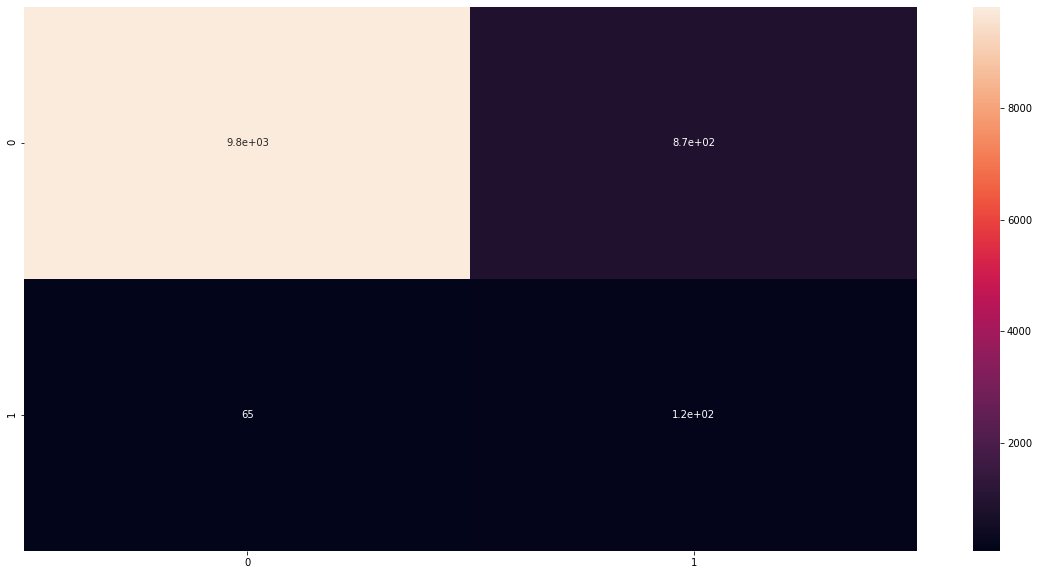

In [43]:
predictions = model.predict(test.drop('label', axis = 1))
temp = test.copy()
temp['predictions'] = predictions
sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot=True)

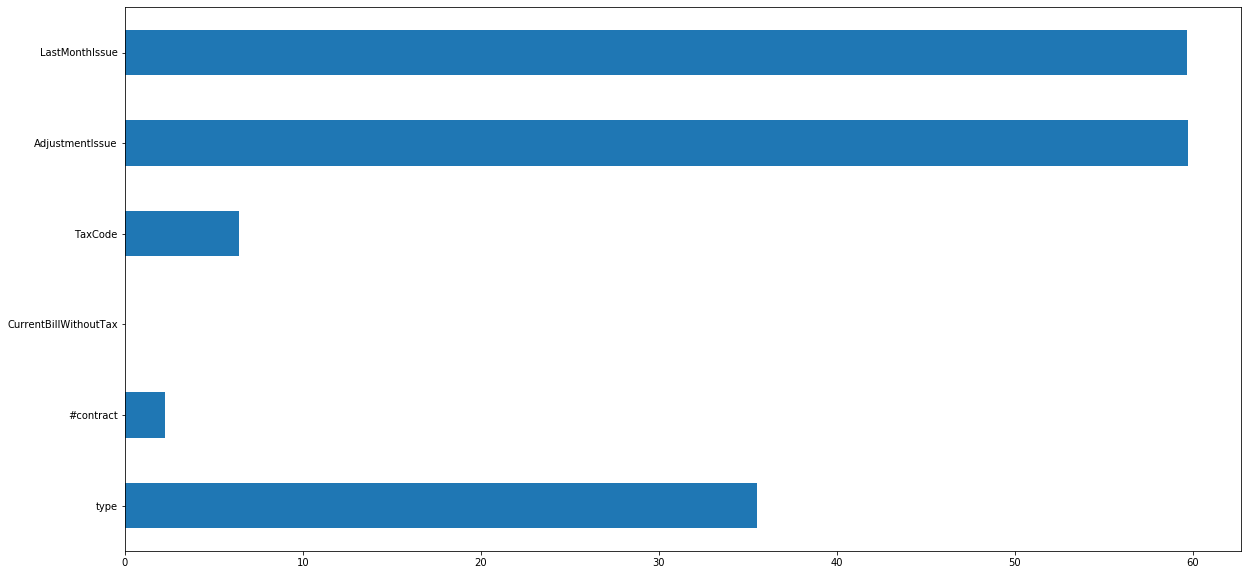

In [44]:
(pd.Series(abs(model.coef_[0]), index = data.drop('label', axis = 1).columns).plot(kind = 'barh'))

In [45]:
f1scores.append(f1_score(temp.label, temp.predictions))
recall.append(recall_score(temp.label, temp.predictions))
precison.append(precision_score(temp.label, temp.predictions))
models.append(type(model).__name__)

## XGBoost

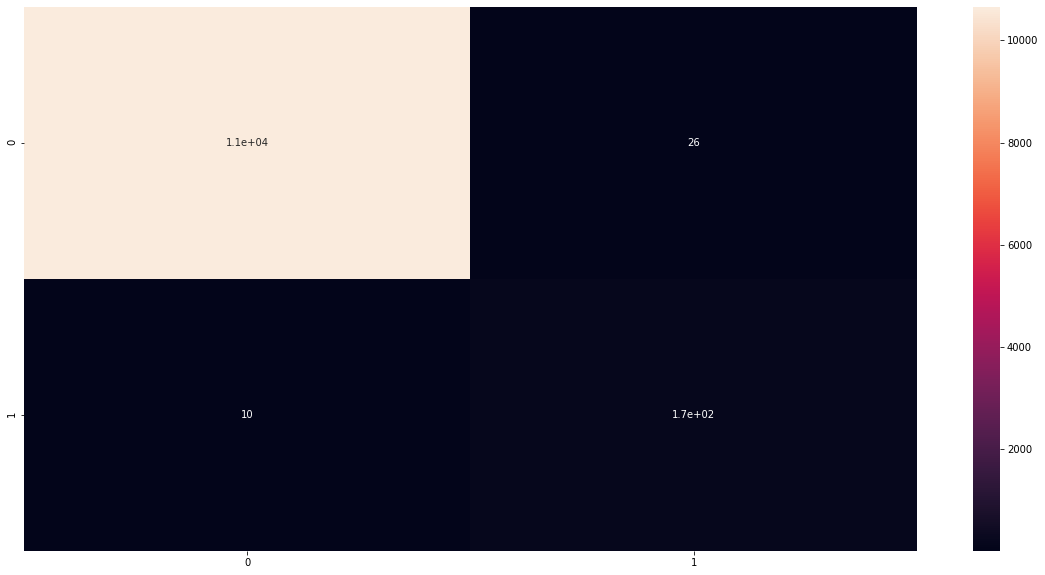

In [46]:
model = XGBClassifier()
model.fit(new_data.drop('label',axis = 1), new_data['label'])
predictions = model.predict(test.drop('label', axis = 1))
predictions = [round(i) for i in predictions]
temp = test.copy()
temp['predictions'] = predictions
sns.heatmap(confusion_matrix(temp.label, temp.predictions),annot=True)

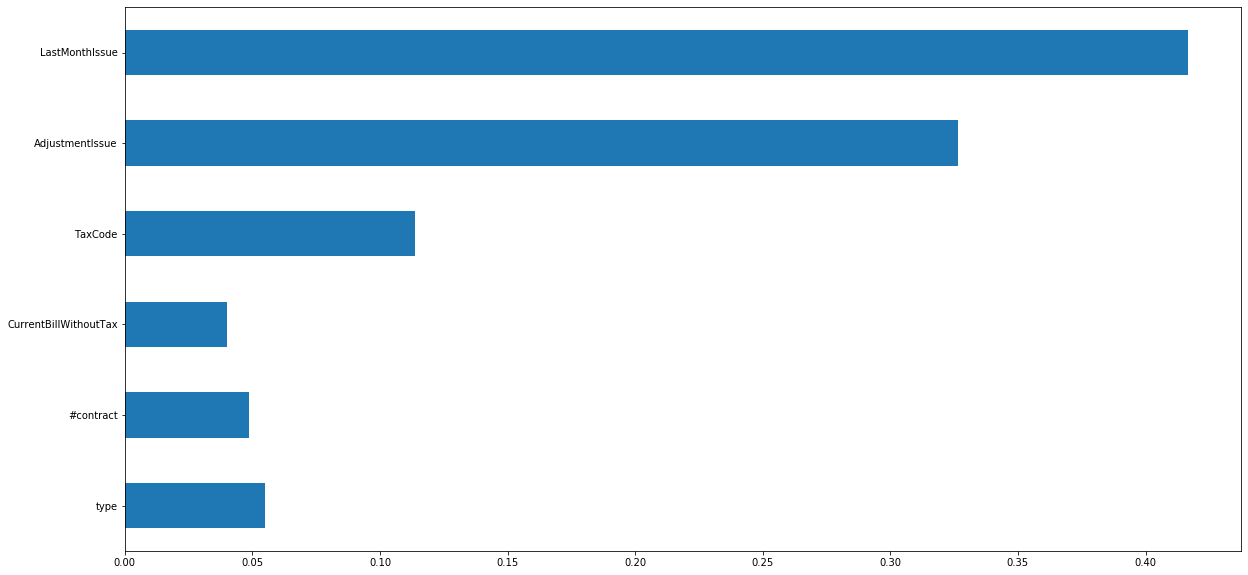

In [47]:
(pd.Series(model.feature_importances_, index = data.drop('label', axis = 1).columns).plot(kind = 'barh'))

In [48]:
f1scores.append(f1_score(temp.label, temp.predictions))
recall.append(recall_score(temp.label, temp.predictions))
precison.append(precision_score(temp.label, temp.predictions))
models.append(type(model).__name__)

In [49]:
results = {}
results['models'] = models
results['f1_score'] = f1scores
results['precison'] = precison
results['recall'] = recall

In [50]:
graph = pd.DataFrame.from_dict(results)
graph.head()

,models,f1_score,precison,recall
0,OneClassSVM,0.050420,0.041096,0.065217
1,IsolationForest,0.342541,0.348315,0.336957
2,LocalOutlierFactor,0.745690,0.617857,0.940217
3,RandomForestClassifier,0.842767,1.000000,0.728261
4,SVC,0.203593,0.120812,0.646739


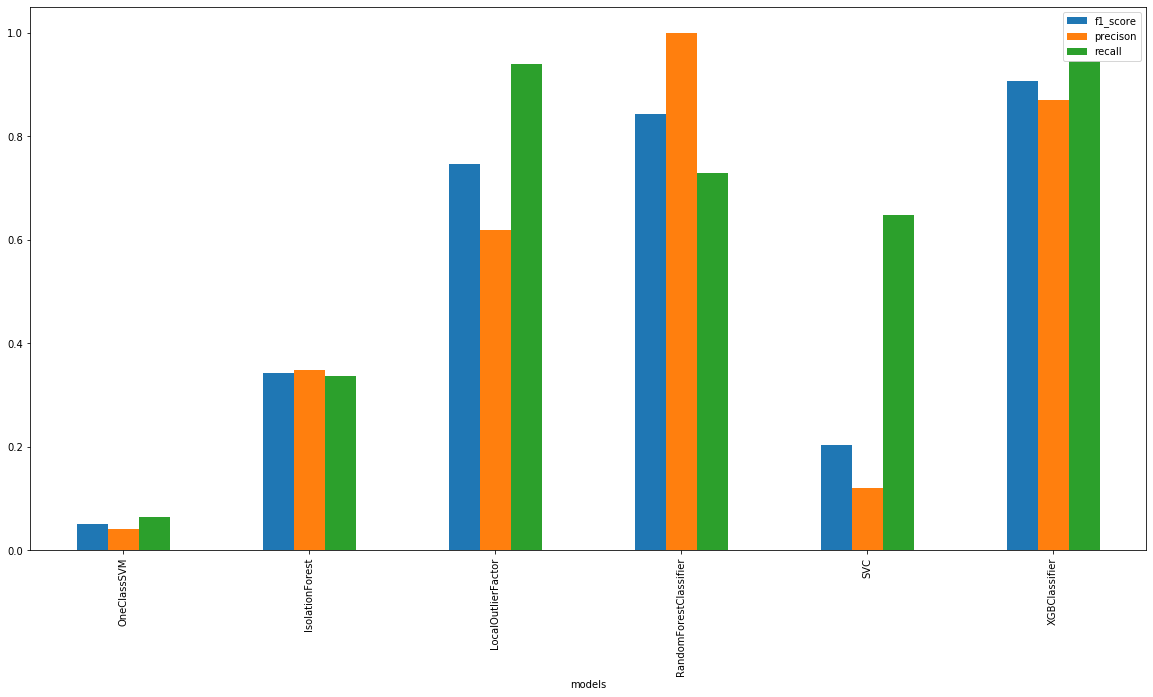

In [51]:
graph.plot(x = 'models',kind = 'bar')